In [181]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Concatenate, Dropout
from keras import regularizers
from keras.models import Model

In [2]:
class SpectralConverter:
    def __init__(self, img_shape: Tuple[int, int]):
        self.img_shape_x = img_shape[0]
        self.img_shape_y = img_shape[1]
        
    def img_to_freq(self, img: np.ndarray, border_shape: Tuple[int, int] = (0, 0)):
        border_x = border_shape[0]
        border_y = border_shape[1]
        
        # Fourier Transform
        f_transform = np.fft.fft2(img)
        f_shift = np.fft.fftshift(f_transform)
        
        # Crop Image
        f_shift_cropped = f_shift[border_y:img.shape[0] - border_y, border_x:img.shape[1] - border_x]
        
        return f_shift_cropped
    
    def freq_to_img(self, freq: np.ndarray):
        img_center_x = self.img_shape_x // 2
        img_center_y = self.img_shape_y // 2
        
        freq_center_x = freq.shape[1] // 2
        freq_center_y = freq.shape[0] // 2
        
        f_shift_cropped = np.zeros((self.img_shape_y, self.img_shape_x), dtype=complex)
        
        f_shift_cropped[img_center_y - freq_center_y:img_center_y + freq_center_y,img_center_x - freq_center_x:img_center_x + freq_center_x] = freq
        
        f_ishift = np.fft.ifftshift(f_shift_cropped)
        f_itransform = np.fft.ifft2(f_ishift)
        
        return np.abs(f_itransform)

# Preprocess Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [48]:
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

In [4]:
converter = SpectralConverter(x_train[0].shape)
border_shape = (11, 11)
x_train_freq = [converter.img_to_freq(img, border_shape) for img in x_train]
x_test_freq = [converter.img_to_freq(img, border_shape) for img in x_test]

In [6]:
x_train_freq_log = np.log1p(np.abs(x_train_freq))
x_test_freq_log = np.log1p(np.abs(x_test_freq))

In [35]:
mean = x_train_freq_log.mean()
std = x_train_freq_log.std()

x_train_freq_log_scaled = (x_train_freq_log - mean) / std
x_test_freq_log_scaled = (x_test_freq_log - mean) / std

In [36]:
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1))
y_test_ohe = ohe.transform(y_test.reshape(-1, 1))

# Build Model

In [182]:
input_image = Input(shape=(28, 28, 1), name='image_input')
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(264, activation='relu')(x)

input_spectrum = Input(shape=(x_train_freq_log_scaled.shape[1], x_train_freq_log_scaled.shape[2], 1), name='spectrum_input')
y = Flatten()(input_spectrum)
y = Dense(264, activation='relu')(y)
y = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2=0.002))(y)

combined = Concatenate()([x, y])
z = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.002, l2=0.002))(combined)
output = Dense(10, activation='softmax')(z)

model = Model(inputs=[input_image, input_spectrum], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 26, 26,    │        640 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 13, 13,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 13, 13,    │          0 │ max_pooling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 11, 11,    │     36,928 │ dropout_8[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 5, 5, 64)  │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectrum_input      │ (None, 6, 6, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 5, 5, 64)  │          0 │ max_pooling2d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_28          │ (None, 36)        │          0 │ spectrum_input[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_27          │ (None, 1600)      │          0 │ dropout_9[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 264)       │      9,768 │ flatten_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 264)       │    422,664 │ flatten_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 128)       │     33,920 │ dense_67[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 392)       │          0 │ dense_66[0][0],   │
│ (Concatenate)       │                   │            │ dense_68[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 128)       │     50,304 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 10)        │      1,290 │ dense_69[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 555,514 (2.12 MB)

 Trainable params: 555,514 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [184]:
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',              
    monitor='val_accuracy',           
    save_best_only=True,          
    mode='max',                   
    verbose=1                     
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',         
    patience=10,                 
    verbose=1,                  
    restore_best_weights=True   
)

In [185]:
history = model.fit([x_train_scaled, x_train_freq_log_scaled], y_train_ohe, epochs=50, batch_size=50, verbose=True, validation_data=([x_test_scaled, x_test_freq_log_scaled], y_test_ohe), callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8873 - loss: 1.8415
Epoch 1: val_accuracy improved from -inf to 0.98260, saving model to best_model.keras
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.8874 - loss: 1.8397 - val_accuracy: 0.9826 - val_loss: 0.1471
Epoch 2/50
1198/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9767 - loss: 0.1598
Epoch 2: val_accuracy did not improve from 0.98260
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.9767 - loss: 0.1598 - val_accuracy: 0.9820 - val_loss: 0.1240
Epoch 3/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9817 - loss: 0.1181
Epoch 3: val_accuracy improved from 0.98260 to 0.98750, saving model to best_model.keras
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.9817 - loss: 0.1181 - val_accuracy: 0.9875 - val_loss: 0.0878
Epoch 4/50
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9849 - loss: 0.0977
Epoch 4: val_accuracy did not improve from 0.98750
1200

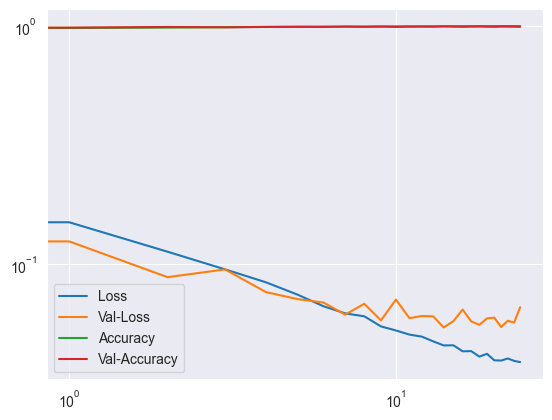

In [187]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val-Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val-Accuracy')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Load Best Model

In [188]:
best_model = tf.keras.models.load_model('best_model.keras')

In [199]:
loss, accuracy = best_model.evaluate([x_test_scaled, x_test_freq_log_scaled], y_test_ohe)
print(f'Accuracy: {accuracy*100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9909 - loss: 0.0635
Accuracy: 99.32%


# Visualize Model

In [200]:
y_pred = best_model.predict([x_test_scaled, x_test_freq_log_scaled])
cm = confusion_matrix(y_test, ohe.inverse_transform(y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


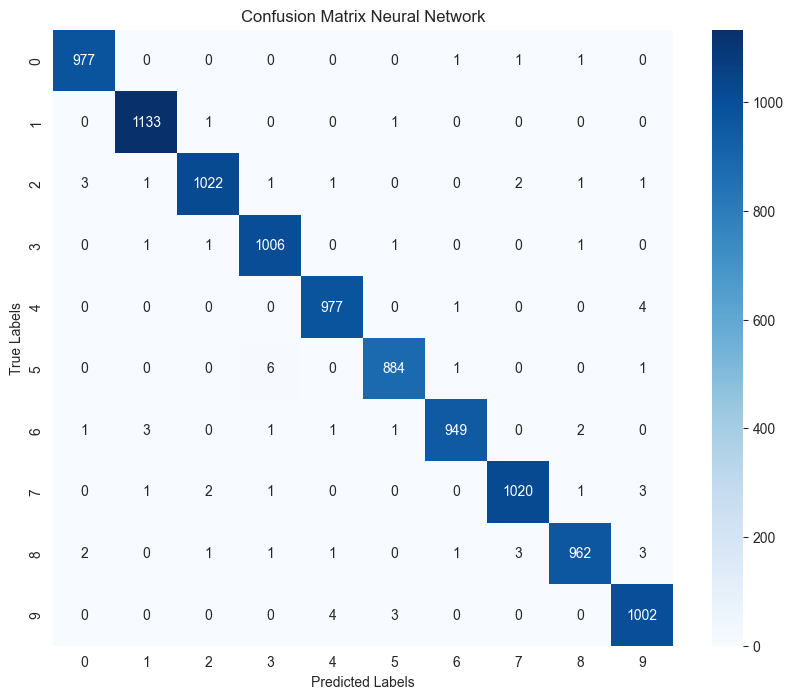

In [201]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Neural Network')
plt.show()

# View wrong Classifications

In [202]:
predictions = np.argmax(best_model.predict([x_test_scaled, x_test_freq_log_scaled]), axis=1)
predict_errors_indexes = np.where(y_test != predictions)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [203]:
x_test_img_error = x_test_scaled[predict_errors_indexes]
x_test_img_spectrum_error = x_test_freq_log_scaled[predict_errors_indexes]
y_test_error = y_test[predict_errors_indexes]
predictions_error = best_model.predict([x_test_img_error, x_test_img_spectrum_error])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


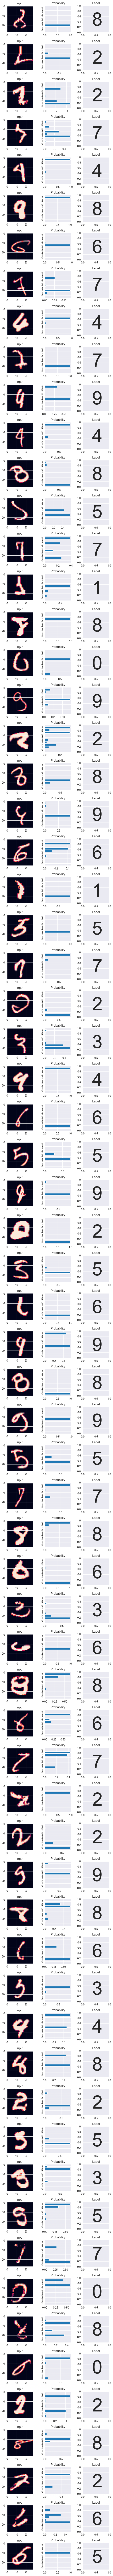

In [204]:
fig, ax = plt.subplots(len(predictions_error), 3, figsize=(6, len(predictions_error) * 2))

for i, prediction in enumerate(predictions_error):
    ax[i, 0].imshow(x_test_img_error[i])
    ax[i, 0].set_title('Input')
    
    ax[i, 1].barh(range(10), prediction)
    ax[i, 1].set_yticks(range(10))
    ax[i, 1].set_title('Probability')
    
    ax[i, 2].text(0.35, 0.25, y_test_error[i], size=70)
    ax[i, 2].set_title('Label')

plt.tight_layout()
plt.show()